# 空间向量数据

## GeoPandas 简介

GeoPandas 的目标是使 python 中的空间数据更容易使用。它结合了 `pandas` 和 `shapely` 的功能，提供了 `pandas` 中的空间运算和多个几何图形的高级接口。GeoPandas 使您能够轻松地用 python 执行运算，否则将需要诸如 PostGIS 这样的空间数据库。

### 数据结构

GeoPandas 实现了两个主要的数据结构，GeoSeries 和 GeoDataFrame。它们分别是 pandas Series 和 DataFrame 的子类。

### GeoSeries 

`GeoSeries` 本质上是向量，其中向量中的每个条目都是一组对应于观察结果的形状。一个条目可能只包含一个形状（如单个多边形）或多个被认为是一个观察结果的形状（如组成夏威夷州或印度尼西亚等国家的多个多边形）。

Geopandas 有三种基本的几何对象（实际上是 shapely 的对象）：

- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

In [1]:
from matplotlib import pyplot as plt
import geopandas as gpd

plt.style.use('bmh') # 更适合绘制几何图形。

In [2]:
from shapely.geometry import Point
s = gpd.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
s

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

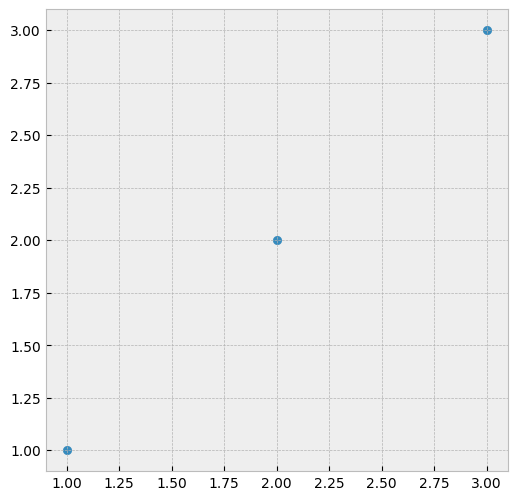

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
s.plot(ax=ax);

In [4]:
from shapely.geometry import LineString
l= gpd.GeoSeries([LineString([Point(-77.036873,38.907192), 
                              Point(-76.612190,39.290386,), 
                              Point(-77.408456,39.412006)])])
l

0    LINESTRING (-77.03687 38.90719, -76.61219 39.2...
dtype: geometry

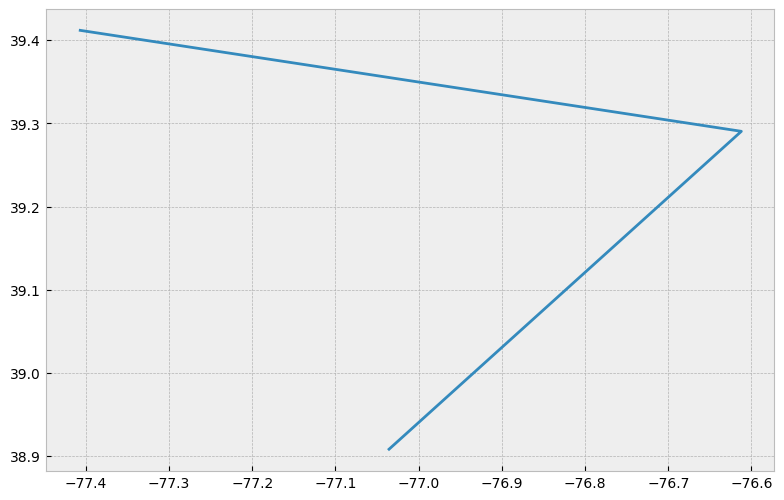

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
l.plot(ax=ax);

In [6]:
from shapely.geometry import Polygon
p= gpd.GeoSeries([Polygon([Point(-77.036873,38.907192),
                           Point(-76.612190,39.290386),
                           Point(-77.408456,39.412006)])])
p

0    POLYGON ((-77.03687 38.90719, -76.61219 39.290...
dtype: geometry

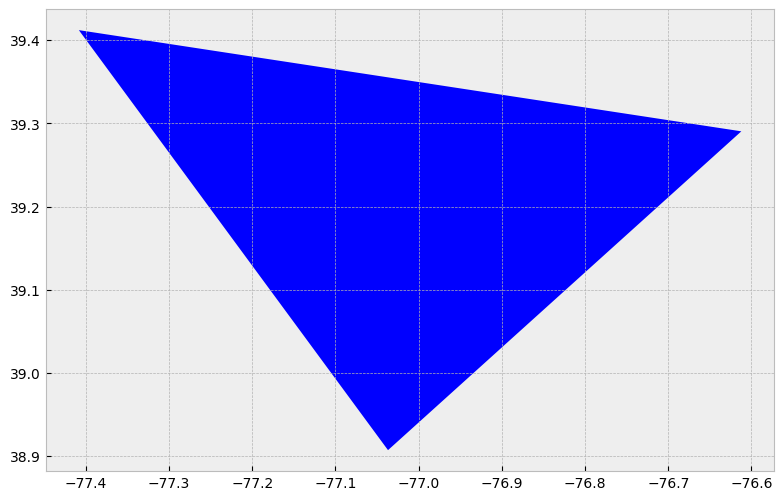

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
p.plot(ax=ax);

注意，`GeoSeries` 中的所有条目不需要具有相同的几何类型，但如果不是这样，某些导出操作将失败。

### GeoDataFrame

`GeoDataFrame` 是包含 `GeoSeries` 的表格式数据结构。

`GeoDataFrame` 最重要的属性是它总是有一个 `GeoSeries` 列，它持有一个特殊的状态。这个 `GeoSeries` 被称为 `GeoDataFrame` 的“几何”。当将空间方法应用到 `GeoDataFrame` （或调用类似 `area` 的空间属性）时，此命令将始终作用于“几何”列。

“几何”列——不管它的名字是什么——都可以通过几何属性（`gdf.geometry`）访问，并且可以通过键入 [`gdf.geometry.name`](http://gdf.geometry.name/) 找到几何列的名称。

```{note}
`GeoDataFrame` 还可以包含具有几何（形状）对象的其他列，但一次只能有一列是活动几何。要更改哪个列是活动几何列，请使用 {meth}`GeoDataFrame.set_geometry` 方法。
```

使用世界 `GeoDataFrame` 的例子：

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


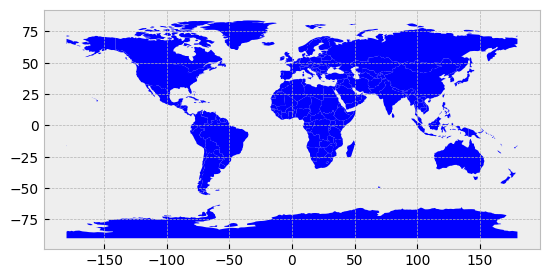

In [9]:
world.plot();

## 空间点线多边形

经常发现处于这样一种情况：需要从头生成新的空间数据，或者需要更好地理解数据是如何构造的。这节课将带您了解一些最常见的数据生成形式。

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
# import fiona
import matplotlib.pyplot as plt
plt.style.use('bmh') # 更适合绘制几何图形。

### 创建 GeoDataFrame 几何

`GeoDataFrame` 对象是 `pandas.DataFrame`，具有几何列的数据帧。空的 `GeoDataFrame` 就是空的，本质上就像 pandas 的那个一样。

创建空的 `GeoDataFrame`，并创建名为 `geometry` 的新列，它将包含 Shapely 对象：

In [11]:
# 创建空白的 geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()
print(newdata)

Empty GeoDataFrame
Columns: []
Index: []


为了有工作的空间数据框架，需要定义一些东西：

### GeoDataFrame 组件

- ``data``：包含所需属性数据的 `pandas.DataFrame`、字典或空列表 `[]`。如果没有数据，则使用 `[]`。
- `crs`：几何对象的坐标参考系（Coordinate Reference System）。可以是 `pyproj.CRS.from_user_input()` 所接受的任何内容，例如权限字符串（例如  “EPSG:4326”）或 WKT 字符串。
- `geometry`：DataFrame 中的列名称，用作几何或 Shapely 点、线或多边形对象。

因为 geopandas 利用了 Shapely 的几何对象，所以可以通过将 Shapely 的几何对象传递到 GeoDataFrame 来从头创建 Shapefile。这是非常有用的，因为它可以很容易地将包含坐标的文本文件转换为 Shapefile。

现在在 GeoDataFrame 中有一个几何列，但是还没有任何数据。

### 从坐标列表中创建点

创建 geopandas 点对象是一个快照！所需要的是坐标对，从中生成 Shapely 点几何对象，然后创建字典，保存该几何和想要的任何属性，以及坐标参考系统。

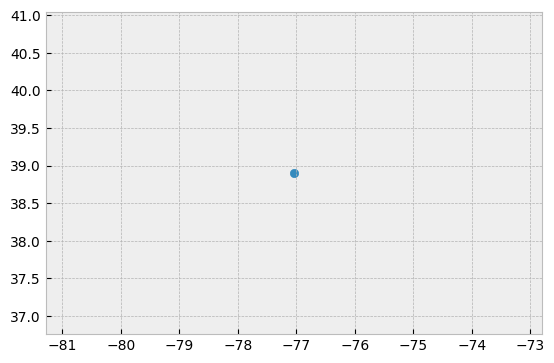

In [12]:
# GW department of geography 的十进制坐标
coordinate = [-77.04639494419096,  38.89934963421794]

# 从坐标对中创建 Shapely
point_coord = Point(coordinate)

# 创建具有所需属性和所需几何列的数据帧
df = {'GWU': ['Dept Geography'], 'geometry': [point_coord]}

# 将 shapely 对象转换为  geodataframe 
point = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326")

# 渲染
point.plot();

可以对存储在 pandas 数据框架中的点集应用相同的过程。

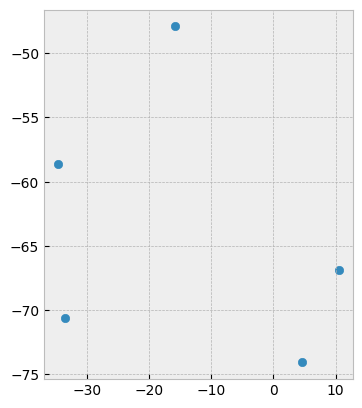

In [13]:
# 属性和坐标列表
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'lat': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'lon': [-58.66, -47.91, -70.66, -74.08, -66.86]})

# 从坐标元组列表中创建 Shapely points
ply_coord = [Point(x, y) for x, y in zip(df.lat, df.lon)]

# 用 crs 转换 shapely 对象到 geodataframe
poly = gpd.GeoDataFrame(df, geometry=ply_coord, crs ="EPSG:4326")
poly.plot();

### 从经纬度（lat, lon） CSV 创建点

最常见的数据创建任务之一是从点列表或 `.csv` 文件创建 shapefile。幸运的是，将这些数据转换成可用的格式非常容易。

首先，必须创建示例 `.csv` 数据集来工作：

In [14]:
import pandas as pd
# 创建 Washington DC 的轮廓，并写入 csv
path_to_csv = 'points.csv'
points = {'Corner':['N','E','S','W'],
          'lon': [-77.0412826538086, -77.11681365966797, -77.01896667480469, -77.0412826538086], 
          'lat': [38.99570671505043, 38.936713143230044, 38.807610542357594, 38.99570671505043]}
points = pd.DataFrame.from_dict(points)
points.to_csv(path_to_csv)              

要从我们的数据创建 `geodataframe`，您只需要将其读入，并使用 `points_from_xy` 将其指向 `df` 的正确列，即 `df` 指定几何列值 `df.lon` 和 `df.lat`。

In [15]:
# 读取点数据
df = pd.read_csv(path_to_csv)

# 从使用 'EPSG' 代码的数据创建 geodataframe，以分配 WGS84 坐标系
points= gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs = 'EPSG:4326')
points

,Unnamed: 0,Corner,lon,lat,geometry
0,0,N,-77.041283,38.995707,POINT (-77.04128 38.99571)
1,1,E,-77.116814,38.936713,POINT (-77.11681 38.93671)
2,2,S,-77.018967,38.807611,POINT (-77.01897 38.80761)
3,3,W,-77.041283,38.995707,POINT (-77.04128 38.99571)


在本例中，`points_from_xy()` 用于将 `lat` 和 `lon` 转换为  `shapely.Point` 对象列表。这将被用作 GeoDataFrame 的几何图形。（`points_from_xy()` 只是 `[Point(x, y) for x, y in zip(df.lon, df.lat)]` 的增强包装器。

```{tip}
- 虽然我们说 "lat lon"，但 python 使用 "lon lat" 代替，这遵循了使用 x, y 作为符号的偏好。
- 通常，像上面的数据一样，这些数据存储在 WGS84 经纬度中，但一定要检查这一点，另一种常见的格式是 UTM 坐标（寻找从东到西约 $500\,000$ 的值，以米为单位）。
```

### 创建空间线条

按照上面的例子，可以很容易地指定线条。在这种情况下，假设有追踪三个骑自行车穿过城镇的人的线。跟踪他们的唯一 id `ID`，他们的位置 X, Y 和他们的速度，并读取以下数据：

In [16]:
from io import StringIO 
data = """
ID,X,Y,Speed
1,  -87.789,  41.976,  16
1,  -87.482,  41.677,  17
2,  -87.739,  41.876,  16
2,  -87.681,  41.798,  16
2,  -87.599,  41.708,  16
3,  -87.599,  41.908,  17
3,  -87.598,  41.708,  17
3,  -87.643,  41.675,  17
"""
# 使用 StringIO 读取文本块
df = pd.read_table(StringIO(data), sep=',')

让我们把这些转换成点来看看。注意，在本例中点不能很好地替代线，我们有三个个体，它们需要分别处理。

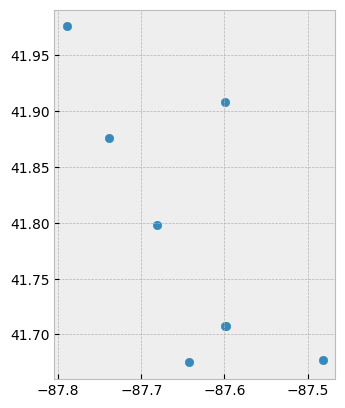

In [17]:
# zip 坐标到点对象，并转换为 GeoDataFrame
points = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = gpd.GeoDataFrame(df, geometry=points, crs = 'EPSG:4326')
geo_df.plot();

现在让将这些数据作为线处理，可以利用列 ID 到 `.groupby`。幸运的是，geopanda `.groupby` 与 pandas 的用法一致。所以这里 `.groupby(['ID'])`，对于每个 ID 组，将值转换为一个列表，并将其存储在 Fiona `LineString` 对象中。

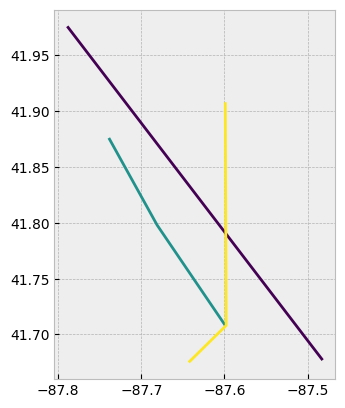

In [18]:
# 把每个点的 `ID` 组看作一条线
lines = geo_df.groupby(['ID'])['geometry'].apply(lambda x:  LineString(x.tolist()))

# 存储为 GeodataFrame 并添加 'ID' 作为列（当前存储为 'index'）
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326") 
lines.reset_index(inplace=True)
lines.plot(column='ID');

现可以看到，每条线都是由 ID 单独处理的，并使用 `.plot(column='ID')` 绘制它们。

### 创建空间多边形

在 geopandas 中创建多边形与其他练习非常相似。首先，从坐标中创建 Fiona 几何对象，将其添加到具有任何属性的数据帧中，然后使用指定的坐标参考系统（coordinate reference system，简称 CRS）创建 GeoDataFrame。

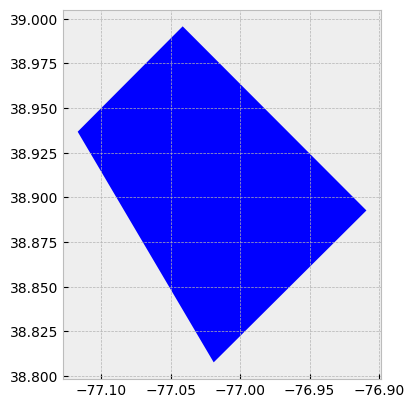

In [19]:
# list of coordindate pairs
coordinates = [[ -77.0412826538086, 38.99570671505043 ], [ -77.11681365966797, 38.936713143230044 ], [ -77.01896667480469, 38.807610542357594],
               [-76.90910339355469,  38.892636142310295]]           

# Create a Shapely polygon from the coordinate-tuple list
ply_coord = Polygon(coordinates)

# create a dictionary with needed attributes and required geometry column
df = {'Attribute': ['name1'], 'geometry': ply_coord}

# Convert shapely object to a geodataframe 
poly = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326")

# Let's see what we have
poly.plot();

### 创建空间点（必须承认这是漫长的过程）

因为 geopandas 利用了 Shapely 的几何对象，所以可以通过将 Shapely 的几何对象传递到 GeoDataFrame 来从头创建 Shapefile。这是非常有用的，因为它可以很容易地将包含坐标的文本文件转换为 Shapefile。

让我们创建空的 GeoDataFrame，并创建名为 geometr 的新列，它将包含我们的 Shapely 对象：

In [20]:
# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()
# Create a new column called 'geometry' to the GeoDataFrame
newdata['geometry'] = None

print(newdata)

Empty GeoDataFrame
Columns: [geometry]
Index: []


创建表示 GWU 地理学系的 Shapely Point，可以将它插入到 GeoDataFrame 中：

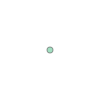

In [21]:
# Coordinates of the GW department of geography in Decimal Degrees
coordinates = (-77.04639494419096,  38.89934963421794)

# Create a Shapely polygon from the coordinate-tuple list
point = Point(coordinates)

# Let's see what we have
point

现在有了合适的 Polygon -object。

将多边形插入到 GeoDataFrame 的“geometry”列中：

In [22]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = point

# Let's see what we have now
newdata

,geometry
0,POINT (-77.04639 38.89935)


现在有了带 Point 的 GeoDataFrame，可以将它导出到 Shapefile中。在 GeoDataFrame 中添加另一列，名为 Location，文本为 GWU Geography。

In [23]:
# Add a new column and insert data
newdata.loc[0, 'Location'] = 'GWU Geography'

# Let's check the data
newdata

,geometry,Location
0,POINT (-77.04639 38.89935),GWU Geography


好了，现在有了额外的有用的信息能够识别特征代表什么。

在导出数据之前，确定 GeoDataFrame 的坐标参考系统（CRS，“投影”）是很有用的。

GeoDataFrame 有叫做 `.crs` 的属性，它显示了在例子中为空（`None`）的数据坐标系统，因为是从头创建数据（例如 `newdata.crs` 返回 `None`）。

为 GeoDataFrame 添加 `crs`。Python 模块 fiona 有很好的 `from_epsg()` 函数，用于传递 GeoDataFrame 的坐标系统。接下来，将使用它，并确定投影到 WGS84 (epsg code:4326)，这是最常见的选择，lat lon CRSs：

In [24]:
# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg

# Set the GeoDataFrame's coordinate system to WGS84
newdata.crs = from_epsg(code = 4326)

# Let's see how the crs definition looks like
newdata.crs

/media/pc/data/4tb/lxw/libs/anaconda3/envs/tvmx/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

最后，可以使用 `GeoDataFrames.to_file()` 导出数据。该函数的工作原理与 numpy 或 pandas 类似，但这里只需要为 Shapefile 提供输出路径。

```python
# Determine the output path for the Shapefile
outfp = r"../temp/gwu_geog.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)
```